In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [8]:
np.random.seed(42)
num_samples = 1008
time_steps = 24
data = np.sin(np.linspace(0, 50, num_samples)) + np.random.normal(0, 0.2, num_samples)
data = data.reshape(-1, time_steps)

data_tensor = torch.tensor(data, dtype=torch.float32)

In [9]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(8, latent_dim)  # Mean of latent space
        self.log_var_layer = nn.Linear(8, latent_dim)  # Variance (log)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std  # Reparametrization trick

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var


In [10]:
# Model & training setup
input_dim = time_steps
latent_dim = 2
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [11]:
# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    x_recon, mu, log_var = vae(data_tensor)
    
    # Compute losses
    recon_loss = loss_fn(x_recon, data_tensor)  # Reconstruction loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL loss
    loss = recon_loss + kl_divergence * 0.0001  # Scale KL divergence
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7873
Epoch 10, Loss: 0.6778
Epoch 20, Loss: 0.4582
Epoch 30, Loss: 0.4161
Epoch 40, Loss: 0.4040
Epoch 50, Loss: 0.3797
Epoch 60, Loss: 0.3687
Epoch 70, Loss: 0.3621
Epoch 80, Loss: 0.3573
Epoch 90, Loss: 0.3529


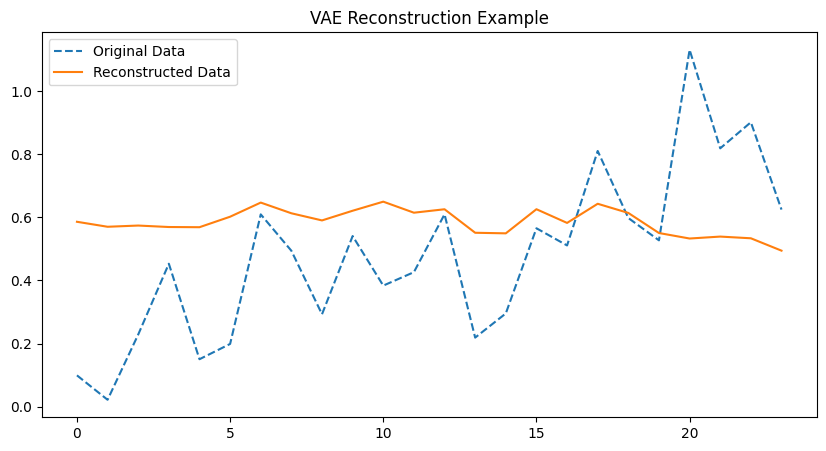

In [12]:
# Visualize original vs reconstructed data
with torch.no_grad():
    sample_input = data_tensor[:10]
    reconstructed, _, _ = vae(sample_input)

plt.figure(figsize=(10, 5))
plt.plot(sample_input[0].numpy(), label="Original Data", linestyle="dashed")
plt.plot(reconstructed[0].numpy(), label="Reconstructed Data", linestyle="solid")
plt.legend()
plt.title("VAE Reconstruction Example")
plt.show()